In [ ]:
import torch

class SinAct(torch.nn.Module):
    def forward(self, x):
        return torch.sin(x)

class Activation(torch.nn.Module):
    def __init__(self, act_name='relu'):
        super(Activation, self).__init__()
        if act_name == 'relu':
            self.act = torch.nn.ReLU()
        elif act_name == 'tanh':
            self.act = torch.nn.Tanh()
        elif act_name == 'sin':
            self.act = SinAct()
        elif act_name == 'sigmoid':
            self.act = torch.nn.Sigmoid()
        elif act_name == 'gelu':
            self.act = torch.nn.GELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        return self.act(x)

def layer(in_dim, inner_dim=8, act_name='relu'):
    return torch.nn.Sequential(
        torch.nn.Linear(in_dim, inner_dim),
        Activation(act_name),
    )

class MLPBlock(torch.nn.Module):

    def __init__(self, in_dim, inner_dim=8, act_name='relu', layers=4, residual=False):
        super(MLPBlock, self).__init__()
        if isinstance(act_name, str):
            act_name = [act_name] * layers
        self.mlp = torch.nn.Sequential(
            *[layer(in_dim, inner_dim, act_name[i]) for i in range(layers)]
        )
        self.residual = residual

    def forward(self, x):
        if self.residual:
            return self.mlp(x) + x
        else:
            return self.mlp(x)

class Encoder(torch.nn.Module):
    def __init__(self, inner_dim=32, blocks=2, layers=4, act_name='relu', second_act='relu', no_residual_first=False):
        super(Encoder, self).__init__()

        self.in_mlp = layer(2, inner_dim)
        self.blocks = torch.nn.ModuleList()
        acts = [act_name, second_act] * layers
        for i in range(blocks):
            residual = i != 0 and not no_residual_first
            self.blocks.append(MLPBlock(inner_dim, inner_dim, acts, layers, residual))
        self.out = torch.nn.Linear(inner_dim, 1)

    def forward(self, x):
        x = self.in_mlp(x)
        for block in self.blocks:
            x = block(x)
        return self.out(x)

class Decoder(torch.nn.Module):
    def __init__(self, inner_dim=32, blocks=2, layers=4, act_name='relu', second_act='relu', no_residual_first=False):
        super(Decoder, self).__init__()
        self.in_mlp = layer(1, inner_dim)
        self.blocks = torch.nn.ModuleList()
        acts = [act_name, second_act] * layers
        for i in range(blocks):
            residual = i != 0 and not no_residual_first
            self.blocks.append(MLPBlock(inner_dim, inner_dim, acts, layers, residual))
        self.out = torch.nn.Linear(inner_dim, 2)


    def forward(self, x):
        x = self.in_mlp(x)
        for block in self.blocks:
            x = block(x)
        return self.out(x)



In [ ]:
num_layers = 1
blocks=50
dim = 256
act = 'sin'
second_act = 'sin'

# num_layers = 2
# blocks=25
# dim = 256
# act = 'relu'
# second_act = 'relu'

no_residual_first = False
encoder = Encoder(dim, blocks, num_layers, act, second_act, no_residual_first).cuda()
decoder = Decoder(dim, blocks, num_layers, act, second_act, no_residual_first).cuda()


In [ ]:
# meshgrid
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
X, Y = torch.meshgrid(x, y)

grid = torch.stack((X, Y), dim=-1).reshape(-1, 2).cuda()



In [ ]:
lr = 4e-5
beta1 = 0.9
beta2 = 0.9
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, betas=(beta1, beta2), weight_decay=0.0)
steps = 3000
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1.0, 0, steps)
batch_size_p = 0.9
eps = 1e-6

consistent_encoding_penalty = 0.0
consistent_decoding_penalty = 0.0
warmup_steps = 50
clip_grad = 1.0

rand_grid = False

for i in range(steps):
    if rand_grid:
        grid_target = torch.rand(int(100 * 100 * batch_size_p), 2, device='cuda')
    else:
        if batch_size_p != 1.0:
            batch_size = int(batch_size_p * 100 * 100)
            indices = torch.randperm(100 * 100)[:batch_size].cuda()
            grid_target = grid[indices]
        else:
            grid_target = grid

    z = encoder(grid_target)
    grid_ = decoder(z)
    loss_mse = torch.nn.functional.mse_loss(grid_, grid_target)
    loss_mae = torch.nn.functional.l1_loss(grid_, grid_target)
    loss = loss_mse
    losses = {"loss_mse": loss_mse.item(),
                "loss_mae": loss_mae.item()}

    if consistent_encoding_penalty > 0 and batch_size_p == 1.0:
        input_diffs = (grid_target[1:] - grid_target[:-1]).norm(dim=-1)
        encoded_diffs = (z[1:] - z[:-1]).norm(dim=-1)
        ratios = encoded_diffs / input_diffs
        log_ratios = torch.log(ratios + eps)
        mean_ratio = log_ratios.mean(dim=0, keepdim=True)
        diff_from_mean = torch.nn.functional.mse_loss(log_ratios, mean_ratio)
        loss += diff_from_mean * consistent_encoding_penalty
        losses["latent_loss"] = (diff_from_mean.item())

    if consistent_decoding_penalty > 0 and batch_size_p == 1.0:
        encoded_diffs = (grid_[1:] - grid_[:-1]).norm(dim=-1)
        decoded_diffs = (grid_target[1:] - grid_target[:-1]).norm(dim=-1)
        ratios = decoded_diffs / (encoded_diffs + eps)
        log_ratios = torch.log(ratios + eps)
        mean_ratio = log_ratios.mean(dim=0, keepdim=True)
        diff_from_mean = torch.nn.functional.mse_loss(log_ratios, mean_ratio)
        loss += diff_from_mean * consistent_decoding_penalty
        losses["observed_loss"] = (diff_from_mean.item())

    print(losses, i, optimizer.param_groups[0]['lr'])
    if i < warmup_steps:
        hold_lr = optimizer.param_groups[0]['lr']
        optimizer.param_groups[0]['lr'] = 0.0

    # loss = loss_mse + loss_mae
    loss.backward()
    if clip_grad > 0:
        torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), clip_grad)
    optimizer.step()
    optimizer.zero_grad()
    if i < warmup_steps:
        optimizer.param_groups[0]['lr'] = hold_lr
    scheduler.step()


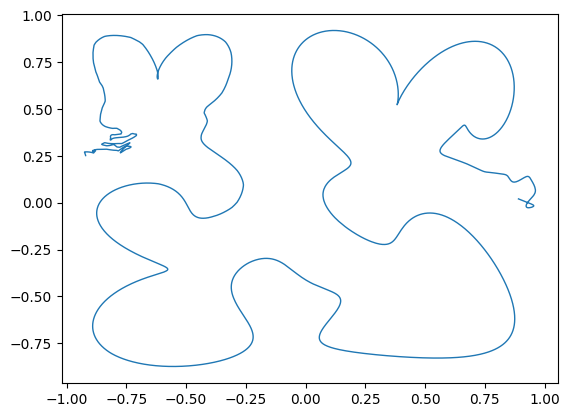

In [ ]:
import matplotlib.pyplot as plt

# plt.figure()
with torch.no_grad():
    z = encoder(grid)
    min_val = z.min().item()
    max_val = z.max().item()
    num_points = 100 * 100 * 2
    # num_points = 100
    z = torch.linspace(min_val, max_val, num_points).reshape(-1, 1).cuda()
    grid_ = decoder(z).cpu()

# for idx in range(z.shape[0]):
#     color = idx / z.shape[0]
#     color = [color, 0, 1 - color]
#     point = grid_[idx]
#     plt.plot(point[0], point[1],) #linewidth=1, markersize=1, color=color)

plt.plot(grid_[:, 0], grid_[:, 1], linewidth=1, markersize=1)

plt.show()

tensor(0.)